## Levantamento do quantitativo de resultados por ano

In [3]:
# !pip install pymed

In [6]:
from pymed import PubMed
pubmed = PubMed(tool="Prospections", email="marcos.aires@fiocruz.br")
results = pubmed.query("Graph Theory", max_results=500)
print(results)

In [11]:
import requests
def count_articles_by_year(term, start_year, end_year):
    """Conta o número de artigos no PubMed para cada ano, dado um termo e um intervalo de anos."""
    # URL base para a API E-utilities
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    
    # Dicionário para armazenar a contagem de artigos por ano
    yearly_counts = {}
    
    # Iterar sobre o intervalo de anos
    for year in range(start_year, end_year + 1):
        # Parâmetros da pesquisa
        search_params = {
            "db": "pubmed",
            "term": f"{term}[Title/Abstract] AND (\"{year}/01/01\"[Date - Publication] : \"{year}/12/31\"[Date - Publication])",
            "retmode": "json",
            "retmax": 1  # Apenas é necessário 1 resultado para obter o campo 'count'
        }
        
        # Realizar a pesquisa para obter o número total de registros para o ano atual
        search_url = base_url + "esearch.fcgi"
        search_response = requests.get(search_url, params=search_params)
        search_data = search_response.json()
        
        # Adicionar o número total de registros para o ano ao dicionário
        print(f"{year} {int(search_data['esearchresult']['count'])}")
        yearly_counts[year] = int(search_data['esearchresult']['count'])
    
    return yearly_counts

In [18]:
# Exemplo de uso
yearly_counts = count_articles_by_year("graph theory", 2000, 2024)
yearly_counts.values()

dict_values([14, 13, 16, 24, 23, 34, 39, 62, 53, 81, 105, 106, 153, 239, 300, 365, 357, 455, 492, 504, 562, 692, 719, 550, 2])

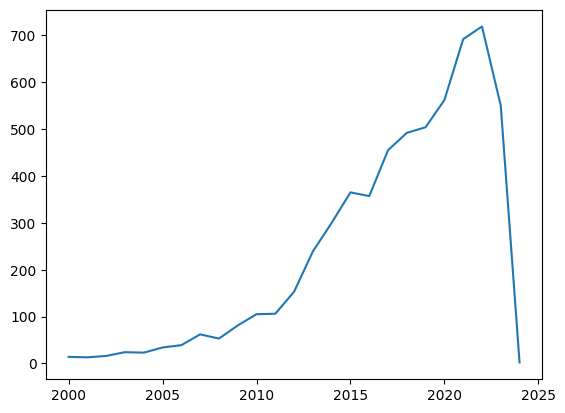

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
pd.Series(yearly_counts).plot()
plt.show()

## Obtenção da lista de id de artigos resultado da busca

In [1]:
import json
import time
import requests
from tqdm import tqdm
from neo4j import GraphDatabase

# Inicializar o driver do Neo4j
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))

# Função para adicionar artigo ao Neo4j
def add_article(tx, title, index):
    tx.run("CREATE (a:Article {title: $title, index: $index})", title=title, index=index)

# Base URL para E-utilities API
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"

# Parâmetros da pesquisa
search_params = {
    "db": "pubmed",
    "term": "graph theory[Title/Abstract] AND (\"2000/01/01\"[Date - Publication] : \"2024/12/31\"[Date - Publication])",
    "retmode": "json",
    "retmax": 200
}

# Realize a pesquisa para obter o número total de registros
search_url = base_url + "esearch.fcgi"
search_response = requests.get(search_url, params=search_params)
search_data = search_response.json()
total_records = int(search_data['esearchresult']['count'])

# Inicializar lista de IDs e barra de progresso
id_list = []
pbar = tqdm(total=total_records)

# Implemente a paginação para coletar todos os registros
batch_size = 200
for start in range(0, total_records, batch_size):
    search_params['retstart'] = start
    search_response = requests.get(search_url, params=search_params)
    search_data = search_response.json()
    new_ids = search_data['esearchresult']['idlist']
    id_list.extend(new_ids)
    
    # Atualizar a barra de progresso
    pbar.update(len(new_ids))
    
    # Persistir os dados preliminares no Neo4j
    with driver.session() as session:
        for i, article_id in enumerate(new_ids):
            session.execute_write(add_article, f"Article ID: {article_id}", start + i)
    
    # Pausa para evitar sobrecarga do servidor
    time.sleep(1)

# Fechar a barra de progresso
pbar.close()

# Obter detalhes de todos os artigos coletados (implementação simplificada)
# Para conjuntos de dados maiores, é recomendável dividir essa etapa em várias chamadas menores
fetch_params = {
    "db": "pubmed",
    "id": ",".join(id_list),
    "retmode": "json"
}

fetch_url = base_url + "esummary.fcgi"
fetch_response = requests.get(fetch_url, params=fetch_params)
fetch_data = fetch_response.json()

# Exemplo simplificado: exibe apenas os títulos dos artigos
# O resumo não é fornecido diretamente pela eSummary, podendo necessitar de chamadas adicionais
for i, article_id in enumerate(id_list):
    article_data = fetch_data['result'][article_id]
    print(f"Article {i + 1}")
    print("Title:", article_data.get("title", "N/A"))
    print("=" * 50)

# Fechar o driver do Neo4j
driver.close()

100%|██████████| 5174/5174 [10:00<00:00,  8.62it/s]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [3]:
fetch_response

<Response [414]>

# Extrair um dado bruto completo

In [ ]:
import requests
import json

# Define the URL and parameters
url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
params = {
    "db": "pubmed",
    "id": "37878454",
    "retmode": "json"  # Or other retmode if you are not receiving JSON
}

# Make the request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Print headers
    print("=== HEADERS ===")
    print(response.headers)
    
    # Print content type
    print("=== CONTENT TYPE ===")
    print(response.headers['Content-Type'])
    
    # Print raw content
    print("=== CONTENT ===")
    print(response.content.decode("utf-8"))
    
    # If the content type indicates JSON, attempt to pretty-print the JSON
    if 'application/json' in response.headers['Content-Type']:
        try:
            parsed = json.loads(response.content)
            print("=== PRETTY-PRINTED JSON ===")
            print(json.dumps(parsed, indent=4, sort_keys=True))
        except json.JSONDecodeError:
            print("Failed to parse as JSON.")
else:
    print(f"Request failed with status code {response.status_code}")


# Classe de extração e persistência metadados PubMed

    https://causalinference.gitlab.io/causal-reasoning-book-chapter1/
    https://www.litmaps.com/
    https://medium.com/@aishweta/graph-networks-traditional-methods-to-extract-features-from-the-of-graph-2e6cd86e5c10

    Nutrition Data Mining:
    https://www.chpc.utah.edu/highlights.php

    Comparative spectral decompositions, such as the GSVD, underlie a mathematically universal description of the genotype-phenotype relations in cancer

    Explainable AI for Health
    Abstract submission deadline
    8 May 2024
    
    Manuscript submission deadline
    8 August 2024
    
    Viewed by
    2448
    https://www.mdpi.com/topics/WP8MJT4789

In [ ]:
# !pip install powerlaw

In [ ]:
import json
import requests
import powerlaw
import numpy as np
from tqdm import tqdm
from time import sleep
from datetime import datetime
from py2neo import Graph, Node
import matplotlib.pyplot as plt

class PubMedAPI:
    def __init__(self, neo4j_url="bolt://localhost:7687", neo4j_user="neo4j", neo4j_password="password"):
        self.base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
        self.graph = Graph(neo4j_url, auth=(neo4j_user, neo4j_password))

    def count_results(self, term):
        base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
        search_url = base_url + "esearch.fcgi"
        
        search_params = {
            "db": "pubmed",
            "term": term,
            "retmode": "json"
        }
        
        search_response = requests.get(search_url, params=search_params)
        search_data = json.loads(search_response.text)
        
        count = int(search_data['esearchresult']['count'])
        return count

    def fetch_article_metadata(self, pubmed_ids):
        try:
            id_list = ",".join(str(id) for id in pubmed_ids)
            fetch_params = {
                "db": "pubmed",
                "id": id_list,
                "retmode": "json"
            }
            fetch_url = self.base_url + "efetch.fcgi"
            fetch_response = requests.get(fetch_url, params=fetch_params)
            fetch_response.raise_for_status()  # Verify if the response is successful

            if fetch_response.status_code == 200:
                content = fetch_response.content.decode("utf-8")
                # rudimentary check for JSON structure
                if content.startswith('{') and content.endswith('}'):
                    try:
                        fetch_data = json.loads(content)
                        return fetch_data['result']
                    except json.JSONDecodeError:
                        print("JSON Decode Error. Fetching metadata failed. Skipping this batch.")
                        return None
                else:
                    print(f"Received non-JSON response: {content}")
                    return None
            else:
                print(f"Request failed with status code {fetch_response.status_code}")
                return None
        except requests.RequestException as e:
            print(f"An error occurred: {e}")
            return None

    def query_pubmed(self, term):
        id_list = self.search_pubmed(term)  # This now gets all IDs
        metadata_collection = []
        
        # Define the batch size and initialize progress bar
        batch_size = 100  # Choose an appropriate batch size
        pbar = tqdm(total=len(id_list))
        
        # Fetch and process articles in batches
        for i in range(0, len(id_list), batch_size):
            batch_ids = id_list[i:i+batch_size]
            metadata_batch = self.fetch_article_metadata(batch_ids)
            
            if metadata_batch is not None:
                # Persist metadata to Neo4j
                self.batch_persist_to_neo4j(metadata_batch)
                
                # Optionally collect metadata for further analysis or operations
                metadata_collection.extend(metadata_batch)
            
            # Update the progress bar
            pbar.update(len(batch_ids))
            
        pbar.close()
        
        # Perform additional operations on the collected metadata if required
        # e.g., generating summary reports, etc.
        
        return metadata_collection

    def batch_persist_to_neo4j(self, metadata_batch):
        # Initialize transaction
        tx = self.graph.begin()
        
        for article_id, article_data in metadata_batch.items():
            if article_id == 'uids':
                continue
            
            # Extract and sanitize metadata
            title = article_data.get('title', 'N/A')
            abstract = article_data.get('abstract', 'N/A')
            pub_date = article_data.get('pubdate', 'N/A')
            
            # Neo4j query to persist metadata
            tx.run("MERGE (a:Artigo {id: $id}) "
                "SET a.title = $title, a.abstract = $abstract, a.pub_date = $pub_date",
                {'id': article_id, 'title': title, 'abstract': abstract, 'pub_date': pub_date})
        
        # Commit the transaction
        tx.commit()

    def search_pubmed(self, term):
        all_ids = []
        offset = 0
        limit = 1000  # This is an example limit; refer to PubMed API documentation for the maximum allowed
        
        while True:
            url = f"https://api.pubmed.gov/v1/{term}?offset={offset}&limit={limit}"
            response = requests.get(url)
            
            if response.status_code != 200:
                print("Failed to retrieve data. Exiting.")
                break
                
            data = response.json()
            ids = data.get('id_list', [])
            
            if not ids:
                break  # Exit the loop if no more ids are returned
                
            all_ids.extend(ids)
            offset += limit  # Update the offset for the next batch
            
        return all_ids

    def persist_to_neo4j(self, metadata):
        for article_id, article_data in metadata.items():
            if article_id == 'uids':
                continue
            title = article_data.get('title', 'N/A')
            abstract = article_data.get('abstract', 'N/A')
            pub_date = article_data.get('pubdate', 'N/A')
            article_node = Node("Artigo", title=title, abstract=abstract, pub_date=pub_date)
            self.graph.merge(article_node, "Artigo", "title")

    def extract_and_persist_article(self, article_id):
        # Fetch article data from PubMed
        fetch_params = {
            'db': 'pubmed',
            'id': article_id,
            'retmode': 'json'
        }
        fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
        fetch_response = requests.get(fetch_url, params=fetch_params)
        fetch_data = json.loads(fetch_response.text)
        
        # Extract relevant article data, gracefully handle missing keys
        article_data = fetch_data['result'].get(article_id, {})
        article_title = article_data.get('title', 'N/A')
        article_abstract = article_data.get('summary', 'N/A')
        article_year = article_data.get('pubdate', 'N/A')
        
        # Persist article data in Neo4j
        self.graph.run("MERGE (a:Artigo {id: $id}) "
                    "SET a.title = $title, a.abstract = $abstract, a.year = $year",
                    {'id': article_id, 'title': article_title, 'abstract': article_abstract, 'year': article_year})

    def create_year_nodes(self, start_year=1990):
        current_year = datetime.now().year
        for year in range(start_year, current_year + 1):
            year_node = Node("Year", year=year)
            self.graph.merge(year_node, "Year", "year")

    def link_articles_to_years(self):
        query = '''
        MATCH (a:Artigo), (y:Year)
        WHERE a.pub_date STARTS WITH toString(y.year)
        MERGE (a)-[:PUBLISHED_IN]->(y)
        '''
        self.graph.run(query)  

    def evaluate_power_law(self, term):
        # Step 1: Collect data for the given term per year
        year_to_count = {}
        for year in range(1990, 2023):  # Adjust the range as needed
            query = f"{term} AND {year}[Date - Publication]"
            count = self.count_results(query)
            year_to_count[year] = count
        
        # Step 2: Perform power-law fit
        data = np.array(list(year_to_count.values()))
        fit = powerlaw.Fit(data)
        
        # Step 3: Goodness-of-fit tests (e.g., Kolmogorov-Smirnov test)
        R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
        
        # Step 4: Print and plot the results
        print(f"R: {R}, p: {p}")
        
        if p < 0.05:
            print("The distribution fits a power law.")
        else:
            print("The distribution does not fit a power law.")
        
        plt.figure(figsize=(10, 6))
        fit.power_law.plot_pdf(color='b', linestyle='--', label='fit ccdf')
        fit.plot_pdf(color='b')
        plt.show()

In [ ]:
# Instantiate class and execute queries for demonstration purposes
if __name__ == "__main__":
    pubmed_api = PubMedAPI()
    ids = pubmed_api.query_pubmed("graph theory", retstart=0, retmax=10)
    metadata = pubmed_api.fetch_article_metadata(ids)
    print(metadata)

## Contagem de resultados para escolher a query

In [ ]:
pubmed_api = PubMedAPI(neo4j_url="bolt://localhost:7687", neo4j_user="neo4j", neo4j_password="password")
term = "graph AND theory"
q1 = pubmed_api.count_results(term)
print(f'{q1:>4}, {term}')

term="graph machine learning"
q2 = pubmed_api.count_results(term)
print(f'{q2:>4}, {term}')

term="graph AND machine AND learning"
q3 = pubmed_api.count_results(term)
print(f'{q3:>4}, {term}')

term="graph theory"
q4 = pubmed_api.count_results(term)
print(f'{q4:>4}, {term}')

In [ ]:
pubmed_api = PubMedAPI(neo4j_url="bolt://localhost:7687", neo4j_user="neo4j", neo4j_password="password")
pubmed_api.query_pubmed(term="graph theory")

In [ ]:
create_year_nodes(self, start_year=1990)
pubmed_api.link_articles_to_years()